In [19]:
 import os
 import plotly
 import plotly.graph_objs as go
 plotly.offline.init_notebook_mode(connected=True)
 import matplotlib.pyplot as plt
 import matplotlib.image as mpimg
 from skimage import measure
 import math
 import numpy as np
 import pandas as pd
 import geopandas as gpd
 from shapely.geometry import Polygon
 %matplotlib inline

Image format: JPEG
Image mode: RGB
Image size: (749, 573)


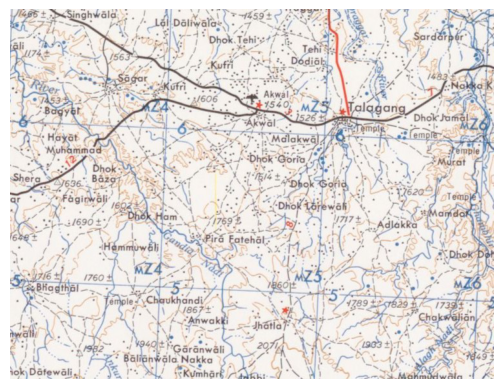

In [20]:
from PIL import Image

# Open the topographic map image
topo_image = Image.open("C://Users//HP//Desktop//New Folder//studyarea.jpg")

# Display basic information about the image
print("Image format:", topo_image.format)
print("Image mode:", topo_image.mode)
print("Image size:", topo_image.size)

import matplotlib.pyplot as plt

# Display the image using Matplotlib
plt.imshow(topo_image)
plt.axis('off')  # Turn off axis
plt.show()


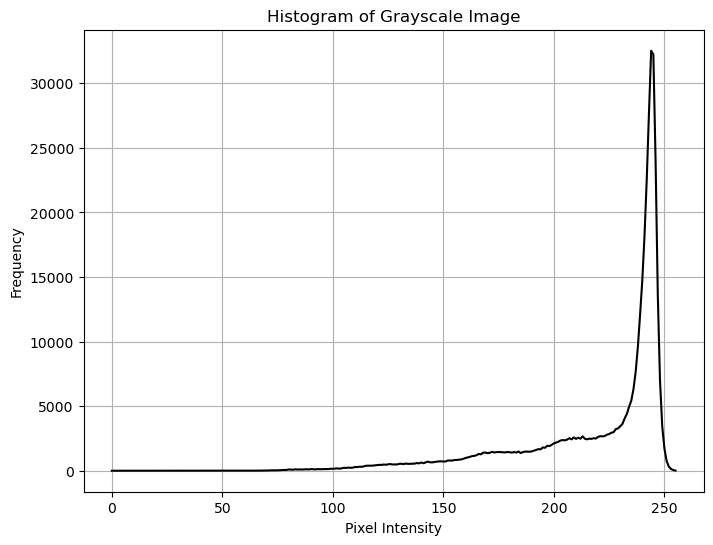

Threshold value selected by Otsu's method: 0.7811771583946079


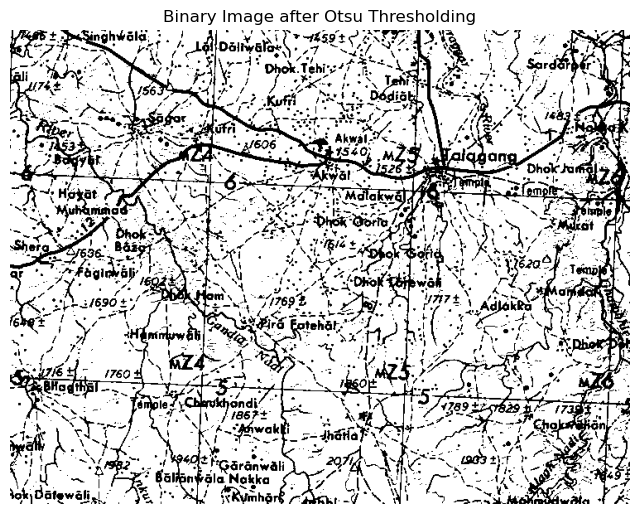

In [22]:
from skimage import io, color, filters
import matplotlib.pyplot as plt

# Load the image
image = io.imread('C://Users//HP//Desktop//New Folder//studyarea.jpg')

# Convert to grayscale
gray_image = color.rgb2gray(image)

# Compute histogram
hist, bins = np.histogram(gray_image.ravel(), bins=256, range=(0, 1))

# Visualize histogram
plt.figure(figsize=(8, 6))
plt.plot(hist, color='black')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Grayscale Image')
plt.grid(True)
plt.show()

# Apply Otsu's thresholding
# Apply Otsu's thresholding
threshold_value = filters.threshold_otsu(gray_image)
print("Threshold value selected by Otsu's method:", threshold_value)
binary_image = gray_image > threshold_value


# Visualize binary image
plt.figure(figsize=(8, 8))
plt.imshow(binary_image, cmap='gray')
plt.axis('off')
plt.title('Binary Image after Otsu Thresholding')
plt.show()


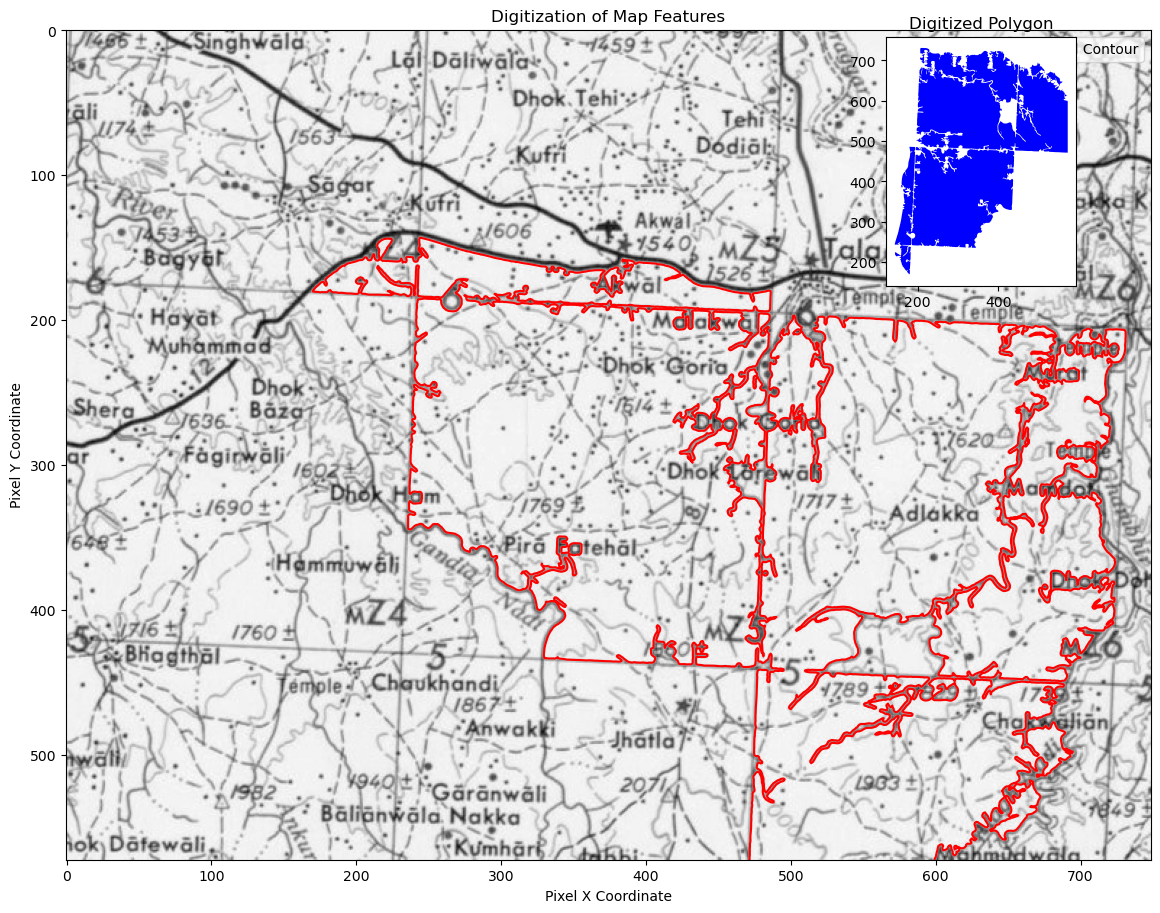

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure, color
import geopandas as gpd
from shapely.geometry import Polygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Load the image
image_path = 'C://Users//HP//Desktop//New Folder//studyarea.jpg'
image = io.imread(image_path)

# Convert image to grayscale if it's not already
if len(image.shape) == 3:
    image = color.rgb2gray(image)

# Find contours at a constant value
contours = measure.find_contours(image, 0.8)

# Assuming there is at least one contour found
largest_contour = sorted(contours, key=lambda x: len(x))[-1]

# Convert the contour points to a polygon shape
polygon = Polygon(largest_contour)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame({'geometry': [polygon]})

# Define the coordinate reference system (CRS)
gdf.crs = "EPSG:4326"  # Update the EPSG code to match the map's coordinate system

# Save to a shapefile
output_path = "C://Users//HP//Desktop//New Folder//digitized_map.shp"
gdf.to_file(output_path)

# Plot the original image
fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(image, cmap='gray', aspect='equal')

# Plot the contour on the image
ax.plot(largest_contour[:, 1], largest_contour[:, 0], color='red', label='Digitized Contour')

# Add labels and legend
ax.set_title('Digitization of Map Features')
ax.set_xlabel('Pixel X Coordinate')
ax.set_ylabel('Pixel Y Coordinate')
ax.legend()

# Create an inset axes for the polygon
ax_inset = inset_axes(ax, width="30%", height="30%", loc='upper right')
gdf.plot(ax=ax_inset, color='blue', aspect='equal')
ax_inset.set_title('Digitized Polygon')

# Show the plot
plt.show()


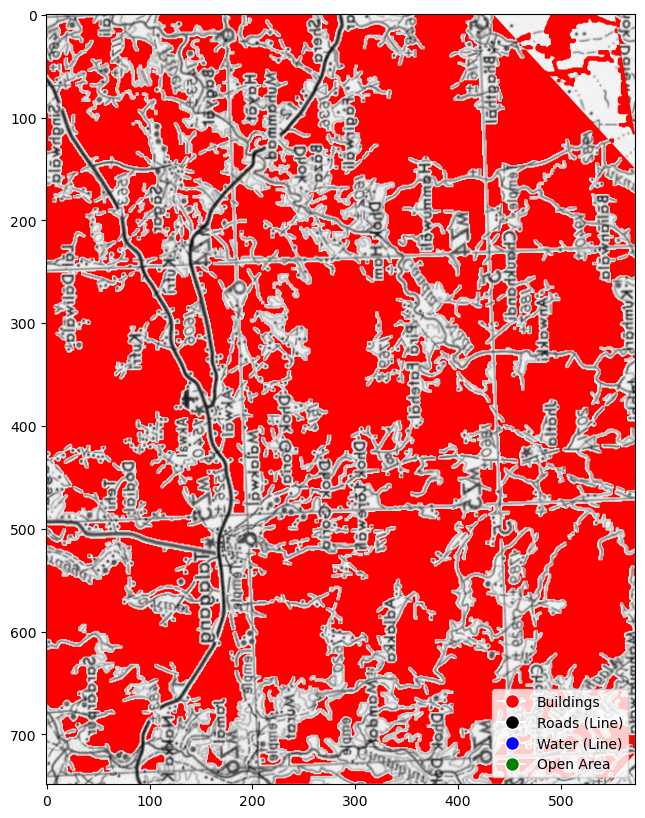

In [24]:
from skimage import io, filters, measure, morphology, color
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, LineString
import numpy as np

# Load the image
image = io.imread('C://Users//HP//Desktop//New Folder//studyarea.jpg')

# Convert to grayscale if it's colored
if image.ndim == 3:
    image = color.rgb2gray(image)

# Apply filters to smooth the image and reduce noise
image_smoothed = filters.gaussian(image, sigma=1)

# Use thresholding to differentiate features
thresholds = {
    'buildings': 0.9,  # Adjust this value based on your image
    'roads': 0.5,      # Adjust this value based on your image
    'water': 0.4,      # Adjust this value based on your image
    "open area": 0.4   # Adjust this value based on your image
}

# List to hold the feature data
features_list = []

for feature, thresh in thresholds.items():
    # Apply threshold
    binary_image = image_smoothed > thresh
    
    # Perform morphological closing to close small holes in the features
    binary_image = morphology.closing(binary_image, morphology.square(3))

    # Find contours
    contours = measure.find_contours(binary_image, 0.7)
    
    # Create polygons or lines for contours based on feature type
    for contour in contours:
        # Skip small contours
        if contour.shape[0] < 60:  # Threshold to be adjusted based on the image scale
            continue
        # Ensure the contour is closed
        if not np.array_equal(contour[0], contour[-1]):
            contour = np.vstack((contour, contour[0]))
        # Create feature geometry based on feature type
        if feature in ['roads', 'water']:
            line = LineString(contour)
            features_list.append({'geometry': line, 'feature_type': feature})
        else:
            poly = Polygon(contour)
            features_list.append({'geometry': poly, 'feature_type': feature})

# Create a GeoDataFrame from the list of features
features_gdf = gpd.GeoDataFrame(features_list)

# Check if GeoDataFrame is empty
if features_gdf.empty:
    print("No features detected.")
else:
    # Rotate the original image by 90 degrees clockwise and invert it
    rotated_inverted_image = np.flip(np.rot90(image, k=-1), axis=1)

    # Plot the rotated and inverted image
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(rotated_inverted_image, cmap='gray')

    # Plot each feature with a different color and add legend
    colors = {'buildings': 'red', 'roads': 'black', 'water': 'blue', "open area": 'green'}
    for feature, color in colors.items():
        subset = features_gdf[features_gdf['feature_type'] == feature]
        if not subset.empty:
            subset.plot(ax=ax, color=color)

    # Remove any aspect ratio settings
    ax.set_aspect('equal')

    # Add legend
    legend_labels = {'buildings': 'Buildings', 'roads': 'Roads (Line)', 'water': 'Water (Line)', 'open area': 'Open Area'}
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors.values()]
    ax.legend(handles, legend_labels.values(), loc='lower right')

    # Show the plot
    plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_8728\3347130583.py:86: UserWarning:

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.



Features saved to: C://Users//HP//Desktop//New Folder//outputs//studyarea_features.shp
Map size: (749, 573)


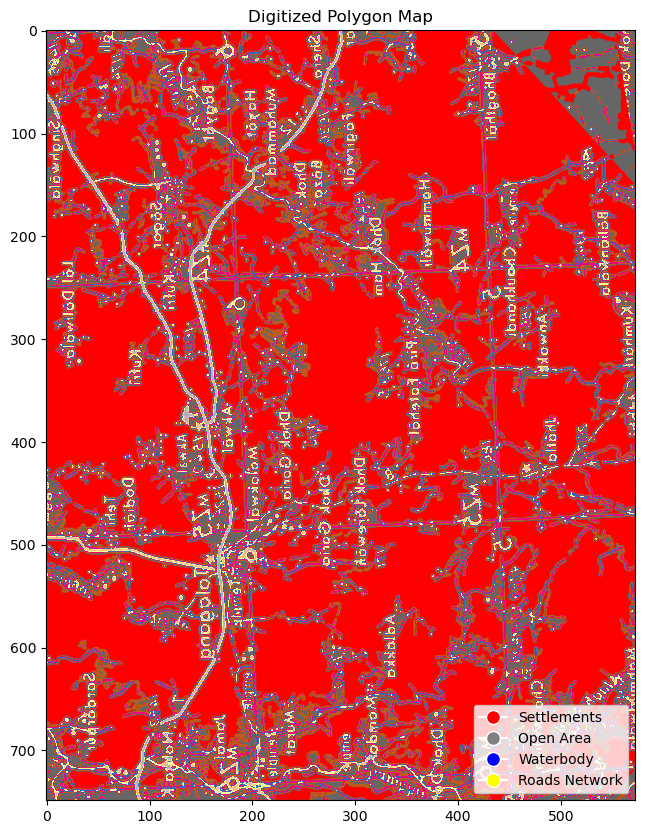

In [25]:
from skimage import io, filters, measure, morphology, color
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, LineString
import numpy as np

# Load the image
image = io.imread('C://Users//HP//Desktop//New Folder//studyarea.jpg')

# Convert to grayscale if it's colored
if image.ndim == 3:
    image = color.rgb2gray(image)

# Apply filters to smooth the image and reduce noise
image_smoothed = filters.gaussian(image, sigma=1)

# Use thresholding to differentiate features
thresholds = {
    'settlements': 0.9,
    'open_area': 0.4,
    'waterbody': 0.3,
    'roads_network': 0.1,
}

# List to hold the feature data
features_list = []

for feature, thresh in thresholds.items():
    # Apply threshold
    binary_image = image_smoothed > thresh
    
    # Perform morphological closing to close small holes in the features
    binary_image = morphology.closing(binary_image, morphology.square(3))

    # Find contours
    contours = measure.find_contours(binary_image, 0.7)
    
    # Create polygons or lines for contours based on feature type
    for contour in contours:
        # Skip small contours
        if contour.shape[0] < 60:  # Threshold to be adjusted based on the image scale
            continue
        # Ensure the contour is closed
        if not np.array_equal(contour[0], contour[-1]):
            contour = np.vstack((contour, contour[0]))
        # Create feature geometry based on feature type
        if feature in ['roads_network', 'waterbody']:
            line = LineString(contour)
            polygon = Polygon(line)
            features_list.append({'geometry': polygon, 'feature_type': feature})
        else:
            poly = Polygon(contour)
            features_list.append({'geometry': poly, 'feature_type': feature})

# Create a GeoDataFrame from the list of features
features_gdf = gpd.GeoDataFrame(features_list)

# Check if GeoDataFrame is empty
if features_gdf.empty:
    print("No features detected.")
else:
    # Rotate the original image by 90 degrees clockwise and invert it
    rotated_inverted_image = np.flip(np.rot90(image, k=-1), axis=1)

    # Plot the rotated and inverted image
    fig, ax = plt.subplots(figsize=(10, 10))  # Increase map size
    ax.imshow(rotated_inverted_image, cmap='Accent')  # Set background color to blue

    # Plot each feature with a different color and add legend
    colors = {'settlements': 'red', 'open_area': 'grey', 'waterbody': 'blue', 'roads_network': 'yellow'}
    for feature, color in colors.items():
        subset = features_gdf[features_gdf['feature_type'] == feature]
        if not subset.empty:
            subset.plot(ax=ax, color=color)

    # Remove any aspect ratio settings
    ax.set_aspect('equal')

    # Add legend
    legend_labels = {'settlements': 'Settlements', 'open_area': 'Open Area', 'waterbody': 'Waterbody', 'roads_network': 'Roads Network'}
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors.values()]
    ax.legend(handles, legend_labels.values(), loc='lower right')
    plt.title('Digitized Polygon Map')
    # Save features to a single file
    shp_path = "C://Users//HP//Desktop//New Folder//outputs//studyarea_features.shp"
    features_gdf.to_file(shp_path, driver='ESRI Shapefile')

    # Print information
    print("Features saved to:", shp_path)
    print("Map size:", rotated_inverted_image.shape)

    # Show the plot
    plt.show()


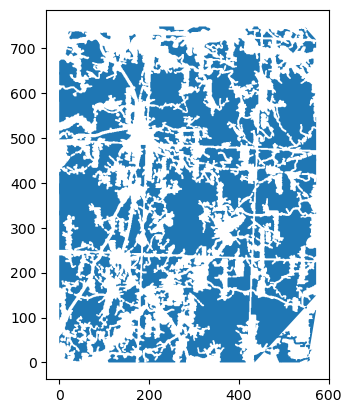

In [26]:
# Read the shapefile
gdf = gpd.read_file(shp_path)

# Plot the shapefile
gdf.plot()
plt.show()